# Mini Project: Dermatologist AI
## Introduction

In this mini project, you will design an algorithm that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, your algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). In this project, you will create a model to generate your own predictions.

Download train images and view sample image to confirm that they have loaded correctly.

In [16]:
#Import test images to confirm 
import numpy as np
from glob import glob

train_files = np.array(glob("data/test/*/*"))

# print number of images in each dataset
print('There are %d total images.' % len(test_files))

There are 600 total images.


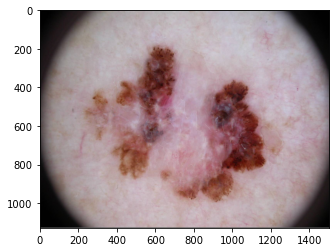

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load color (BGR) image
img = cv2.imread(train_files[0])
   
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

## Data Loading 
Create dataloaders of the training, validation and test datasets.

In [26]:
#ImageFolderWithPaths overwrites the _getitem_ method of datasets.ImageFolder to allow the folder path data 
#to be included with the image data
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [33]:
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size = 20

train_transform = transforms.Compose([
                            transforms.RandomRotation(30),
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                 (0.229, 0.224, 0.225))])
valid_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                 (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder('data/train', transform=train_transform)
valid_data = datasets.ImageFolder('data/valid', transform=valid_transform)
test_data = ImageFolderWithPaths('data/test', transform=valid_transform)
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=num_workers, shuffle=True)
    
loaders_scratch = dict()
loaders_scratch = {'train':train_loader,'valid':valid_loader, 'test':test_loader}

In [34]:
len(loaders_scratch['test'])

600

## Model Creation

As a starting point, we will be finetuning the existing VGG16 model. Freezing the existing weights, loading the VGG16 model and then replacing the final layer with a new one of 3 classes for our 3 images types.

In [5]:
import torch
import torchvision.models as models

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

input = model_transfer.classifier[6].in_features
out = 3
new_layer = nn.Linear(input,out)
model_transfer.classifier[6] = new_layer
print(model_transfer.classifier[6].in_features,model_transfer.classifier[6].out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()

4096 3


## Define Criterion and Optimizer

In [7]:
import torch.optim as optim

### TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

## Define the training model

In [8]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [9]:
# train the model
model_transfer = train(20, loaders_scratch, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.091466 	Validation Loss: 0.993918
Validation loss decreased (inf --> 0.993918).  Saving model ...
Epoch: 2 	Training Loss: 0.976485 	Validation Loss: 1.542710
Epoch: 3 	Training Loss: 0.990875 	Validation Loss: 0.792874
Validation loss decreased (0.993918 --> 0.792874).  Saving model ...
Epoch: 4 	Training Loss: 0.848966 	Validation Loss: 0.833080
Epoch: 5 	Training Loss: 0.869223 	Validation Loss: 0.712066
Validation loss decreased (0.792874 --> 0.712066).  Saving model ...
Epoch: 6 	Training Loss: 0.829688 	Validation Loss: 0.687984
Validation loss decreased (0.712066 --> 0.687984).  Saving model ...
Epoch: 7 	Training Loss: 0.783910 	Validation Loss: 0.689466
Epoch: 8 	Training Loss: 0.740771 	Validation Loss: 0.817962
Epoch: 9 	Training Loss: 0.722100 	Validation Loss: 0.919705
Epoch: 10 	Training Loss: 0.721117 	Validation Loss: 0.641807
Validation loss decreased (0.687984 --> 0.641807).  Saving model ...
Epoch: 11 	Training Loss: 0.671844 	Validation Lo

## Define test function

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    results = {}

    model.eval()
    for batch_idx, (data, target, filename) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        results[filename] = output
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return results

## Load saved training model and then use it to test model accuary

In [10]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [35]:
predictions = test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.861139


Test Accuracy: 70% (420/600)


##### Transfer model was 70% accurate based just on finetuning the VGG16 model. 

In [ ]:
model_transfer(test_loader[0])

In [38]:
print(predictions.key)

AttributeError: 'dict' object has no attribute 'key'